# DS200A Computer Vision Assignment
---

In this section, we select between 15 and 20 features to focus the model on. We add these feature values and identify highly-correlated ones that could be removed/grouped.

## Feature Selection (NB2b) - Table of contents

> ### Part 1. [Retrieve cleaned images from NB1](#fetch)
> ### Part 2. [Create feature functions](#create_features)
> ### Part 3. [Identify highly correlated features](#correlation)

---

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_doh, peak_local_max
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import filters 

import seaborn as sns 
import scipy
import scipy.cluster
import binascii
import os
import time 

# External libraries not part of Jupyter dependencies 
!pip install opencv-python     
import cv2
!pip install webcolors
import webcolors 
!pip install Pillow
from PIL import Image

<a id="fetch"></a>

### Part 1. Retrieve cleaned images from NB1 

Now that we've cached pickle files from NB1, we can retrieve them without having to rerun NB1.

In [4]:
def get_cleaned_images(isTest=False):
    """
    Returns the cleaned training or validation set images.
    
    Keyword arguments: 
    isTest (bool) -- test set if True, train set if False. 
    
    Returns: 
        pd.DataFrame with cleaned images. 
    """
    cache_name = 'cleaned_test.pkl' if isTest else 'cleaned_train.pkl'
        
    if Path(cache_name).is_file():
        image_df = pd.read_pickle(cache_name)
        print(f"Success: {len(image_df)} images loaded into {'test' if isTest else 'train'} dataframe")
        return image_df
    else:
        print("Error: data file does not exist. Please create it in part 1!")

training_data = get_cleaned_images()
validation_data = get_cleaned_images(isTest=True)

Success: 1501 images loaded into train dataframe
Success: 716 images loaded into test dataframe


<a id="create_features"></a>

### Part 2. Create features

#### 2.1 Define functions to return feature values
Here I create several feature functions to describe the images. Not all of these will be useful, but I'll deal with that in a later section.

In [5]:
def ft0(images):
    """ Returns the pixel size of the image arrays"""
    return images.size

def ft1(images):
    """ Returns the average of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.mean ( red_channel )
    
def ft2(images): 
    """ Returns aspect ratio of the image arrays """
    return images.shape[1] / images.shape[0]

def ft3(images):
    """ Returns the average of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.mean ( green_channel )
        
def ft4(images):
    """ Returns the average of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.mean ( blue_channel )

def ft5(images):
    """ Returns the median of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.median ( red_channel )

def ft6(images):
    """ Returns the median of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.median ( green_channel )
    
def ft7(images):
    """ Returns the median of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.median ( blue_channel )

def ft8(images):
    """ Returns the stdev of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.std ( red_channel )
    
def ft9(images):
    """ Returns the stdev of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.std ( green_channel )

def ft10(images):
    """ Returns the stdev of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.std ( blue_channel )
    
def ft11(images):
    """Returns the mean luminance for the images in the array """
    return np.mean(rgb2gray(images))

def ft12(images):
    """Returns the median luminance for the image array"""
    return np.median(rgb2gray(images))

def ft13(images):
    """ Returns the stdev luminance for the images """
    return np.std(rgb2gray(images))

def ft14(images):
    """ Returns number of interest points in image using ORB """
    # initiate STAR detector
    orb = cv2.ORB_create() 
    
    # find keypoints with ORB
    keypoints = orb.detect(images, None) 
    
    # compute descriptors with ORB
    keypoints, des = orb.compute(images, keypoints) 
    return len(keypoints)


def ft15(images):
    """ Returns number of blobs (i.e. connected areas) in images using Hessian """
    image_gray = rgb2gray(images)
    blobs_hessian = blob_doh(image_gray, 
                             max_sigma=30, 
                             threshold= 0.01)
    return len(blobs_hessian)

def ft16(images):
    """Returns number of peaks (i.e. local max in a region) of images """
    local_max_coordinates = peak_local_max(images)
    return len(local_max_coordinates)

def ft17(images):
    """
    Returns the average luminance of the filtered images.
    This is used to approximate the amount of edges in the image
    """
    return np.mean(filters.sobel(rgb2gray(images)))

#### 2.2 Write simple unit tests to ensure correctness
Images are represented in deeply nested np.arrays. These can be slightly difficult to work with and error-check. As such, I defined some simple tests to ensure the functions were doing what I expected.

In [6]:
def test_ft1(image):
    assert ft1(image) == np.mean([2,4,10,12,20,40,100,120]), \
        f"Answer received: {ft1(image)}, Answer expected:{np.mean([2,4,10,12,20,40,100,120])}"
    print("PASS ft1 test")

def test_ft2(image):
    assert ft2(image) == 2, \
        f"Answer received: {ft2(image)}, Answer expected: 2"
    print("PASS ft2 test")
    
def test_ft3(image):
    assert ft3(image) == np.mean([0,0,1,3,4,5,5,6]), \
        f"Answer received: {ft3(image)}, Answer expected:{np.mean([0,0,1,3,4,5,5,6])}"
    print("PASS ft3 test")
    
def test_ft4(image):
    assert ft4(image) == np.mean([5,5,6,7,7,8,9,10]), \
        f"Answer received: {ft4(image)}, Answer expected:{np.mean([5,5,6,7,7,8,9,10])}"    
    print("PASS ft4 test")

def test_ft5(image):
    assert ft5(image) == np.median([2,4,10,12,20,40,100,120]), \
        f"Answer received: {ft5(image)}, Answer expected:{np.mean([2,4,10,12,20,40,100,120])}"
    print("PASS ft5 test")

def test_ft6(image):
    assert ft6(image) == np.median([0,0,1,3,4,5,5,6]), \
        f"Answer received: {ft6(image)}, Answer expected:{np.median([0,0,1,3,4,5,5,6])}"
    print("PASS ft6 test")

def test_ft7(image):
    assert ft7(image) == np.median([5,5,6,7,7,8,9,10]), \
        f"Answer received: {ft7(image)}, Answer expected:{np.median([5,5,6,7,7,8,9,10])}"  
    print("PASS ft7 test") 

def test_ft8(image):
    assert ft8(image) == np.std([2,4,10,12,20,40,100,120]), \
        f"Answer received: {ft8(image)}, Answer expected:{np.std([2,4,10,12,20,40,100,120])}" 
    print("PASS ft8 test")

def test_ft9(image):
    assert ft9(image) == np.std([0,0,1,3,4,5,5,6]), \
        f"Answer received: {ft9(image)}, Answer expected:{np.std([0,0,1,3,4,5,5,6])}" 
    print("PASS ft9 test")

def test_ft10(image):
    assert ft10(image) == np.std([5,5,6,7,7,8,9,10])  , \
        f"Answer received: {ft10(image)}, Answer expected:{np.std([5,5,6,7,7,8,9,10])}" 
    print("PASS ft10 test")  

In [7]:
def run_all_tests():
    """ Runs our simple feature function test suite on an image """
    image = np.array([[ [2, 0, 5],
                    [4, 0, 5],
                    [10, 1, 6],
                    [12, 3, 7]],

                   [[20, 4, 7],
                    [40, 5, 8],
                    [100, 5, 9],
                    [120, 6, 10]]])
    test_ft1(image)
    test_ft2(image)
    test_ft3(image)
    test_ft4(image)
    test_ft5(image)
    test_ft6(image)
    test_ft7(image)
    test_ft8(image)
    test_ft9(image)
    test_ft10(image)
    print("----\nALL TESTS PASSED!")
    
run_all_tests()

PASS ft1 test
PASS ft2 test
PASS ft3 test
PASS ft4 test
PASS ft5 test
PASS ft6 test
PASS ft7 test
PASS ft8 test
PASS ft9 test
PASS ft10 test
----
ALL TESTS PASSED!


### Part 3. Create new dataframe with all features
Now that I've defined the above functions, I will add these features to the raw data.

In [8]:
#Returns data-frame with all the features now inside, and calculated
def feature_frame(images_df, isTest=False, isCache=True):
    """
    Runs all the feature functions on the image dataframe.
    
    Keyword arguments: 
    images_df (pd.DataFrame) -- DataFrame containing all images
    isTest (bool) -- True featurizes test set, False featurizes train set.
    isCache (bool) -- True loads featurized images from cache if exists, false overwrites. 
    
    Returns: 
        pd.DataFrame with all images and their features 
    """
    num_features = 18
    image_series = images_df['image']
    
    cache_file = 'features_test.pkl' if isTest else 'features_train.pkl'
    if Path(cache_file).is_file() and isCache: 
        return pd.read_pickle(cache_file)
    
    features = [f'ft{x}' for x in range(0, num_features)] 
    for feature in features:
        print(f"Started feature: {feature}")
        start = time.time()
        images_df[feature] = eval(f"np.vectorize({feature})(image_series)")
        print(f"Feature '{feature}' took {round(time.time() - start, 2)} seconds")    
    
    if not Path(cache_file).is_file(): 
        images_df.to_pickle(f"./{cache_file}")
        
    print(f"Featurization of {'test' if isTest else 'train'} set completed!\n")
        
    return images_df

In [9]:
# New data-frames with all features
validation_features_df = feature_frame(validation_data, isTest=True, isCache=True)
training_features_df = feature_frame(training_data, isTest=False, isCache=True)

Started feature: ft0
Feature 'ft0' took 0.0 seconds
Started feature: ft1
Feature 'ft1' took 0.09 seconds
Started feature: ft2
Feature 'ft2' took 0.0 seconds
Started feature: ft3
Feature 'ft3' took 0.08 seconds
Started feature: ft4
Feature 'ft4' took 0.08 seconds
Started feature: ft5
Feature 'ft5' took 0.39 seconds
Started feature: ft6
Feature 'ft6' took 0.39 seconds
Started feature: ft7
Feature 'ft7' took 0.39 seconds
Started feature: ft8
Feature 'ft8' took 0.48 seconds
Started feature: ft9
Feature 'ft9' took 0.48 seconds
Started feature: ft10
Feature 'ft10' took 0.48 seconds
Started feature: ft11
Feature 'ft11' took 4.08 seconds
Started feature: ft12
Feature 'ft12' took 5.39 seconds
Started feature: ft13
Feature 'ft13' took 6.83 seconds
Started feature: ft14
Feature 'ft14' took 3.99 seconds
Started feature: ft15
Feature 'ft15' took 141.27 seconds
Started feature: ft16
Feature 'ft16' took 10.09 seconds
Started feature: ft17
Feature 'ft17' took 8.53 seconds
Featurization of test set com

<a id="correlation"></a>
### Part 3. Identify highly-correlated features
It can be problematic for linear approximators if the features are highly correlated or have multicollinearity. Ideally, one would systematically remove these features, or group them appropriately to remove this. Here, I create a simple heatmap, which can be used to identify which features are correlated. 

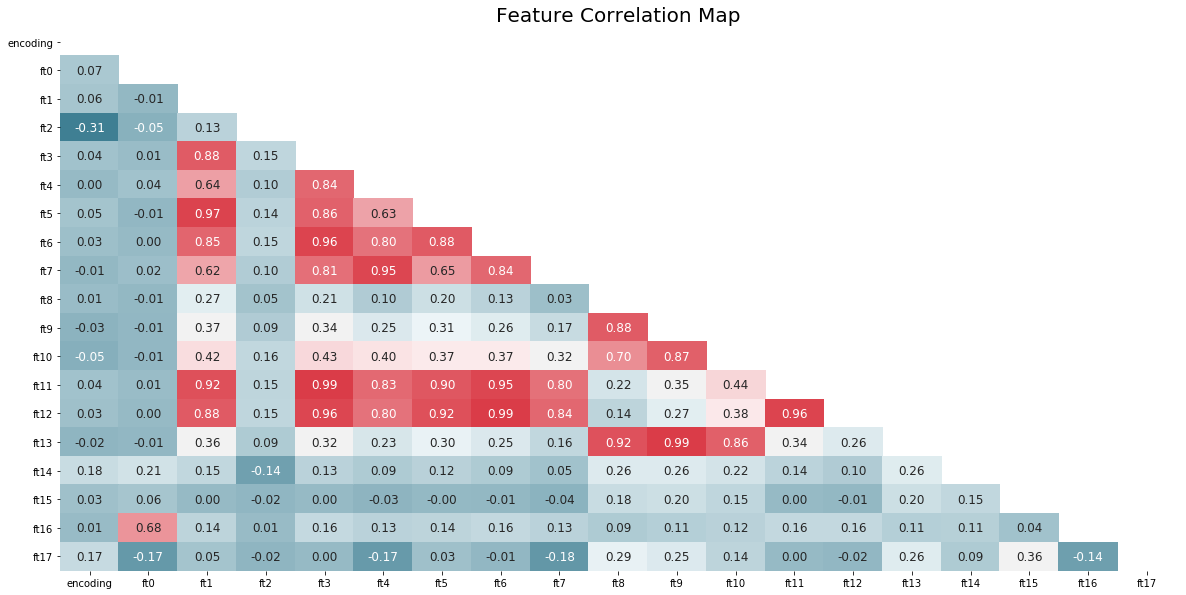

In [10]:
def correlation_plot(df, mirror):
    """
    Creates a heatmap displaying correlation between features
    
    Keyword arguments: 
    df (pd.DataFrame) -- DataFrame of data with feature values
    mirror (bool) -- True creates full map, False creates half map
    
    Returns: 
        heatmap where numbers/colors indicate correlation
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(20, 10))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    if mirror is False:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True 
        colormap = sns.diverging_palette(220, 10, as_cmap=True)
    else:
        mask = False
    sns.heatmap(corr, cmap=colormap, cbar=False, annot=True, fmt=".2f", 
                mask=mask, annot_kws={'size':12})
    plt.title('Feature Correlation Map', fontsize=20)
    plt.show()

correlation_plot(df=pd.DataFrame(training_features_df), mirror=False)